# Problema de Negócio Proposto:

"Prever a cotação da ação VALE3 considerando a volatilidade do preço do minério de ferro e a demanda global por commodities, para auxiliar investidores a tomar decisões estratégicas de curto e médio prazo."

* Importação das bibliotecas:

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as scs
from scipy.stats import linregress
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from prophet import Prophet
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# 1. Análise Exploratória e Tratamento de Dados:

In [2]:
# Vamos baixar as ações da Vale S.A:
vale = yf.download('VALE3.SA', start='2018-01-01', end='2024-12-31', multi_level_index=False)
vale = vale[['Close', 'Open', 'Volume']]
vale = vale.reset_index()
vale['Date'] = pd.to_datetime(vale['Date'])
vale.set_index('Date', inplace=True)
vale


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Close,Open,Volume
Date,,,
2018-01-02,23.603912,22.879726,14156500
2018-01-03,23.462473,23.666150,12744200
2018-01-04,23.558651,23.654833,18433000
2018-01-05,23.926401,23.519046,15251300
2018-01-08,24.458223,23.988636,14542800
...,...,...,...
2024-12-20,52.568302,51.413377,64919500
2024-12-23,52.789661,52.616422,18587900
2024-12-26,52.943653,52.789663,13155800


* Antes de fazermos um tratamento de outliers, vamos verificar a descrição dos dados plotar um boxplot:

In [3]:
vale.describe()

,Close,Open,Volume
count,1738.000000,1738.000000,1.738000e+03
mean,48.509669,48.559934,2.517645e+07
std,16.465244,16.489259,1.264600e+07
min,20.606255,21.482474,0.000000e+00
25%,30.701644,30.736969,1.721538e+07
50%,54.847038,54.849190,2.259590e+07
75%,60.195614,60.493449,2.988118e+07
max,79.544830,79.423084,1.835345e+08


Text(0.5, 1.0, 'Boxplot dos preços de fechamento e abertura da VALE3.')

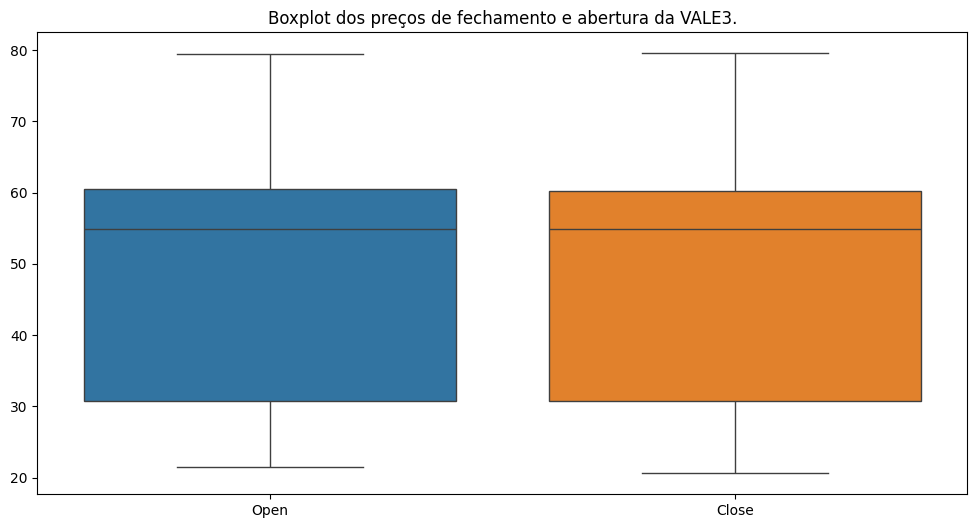

In [4]:
# Vamos visulizar os dados com ajuda de um boxplot:
plt.figure(figsize=(12,6))
sns.boxplot(data=vale[['Open','Close']])
plt.title('Boxplot dos preços de fechamento e abertura da VALE3.')

* Agora vamos agrupar as ações por meses e anos:

In [5]:
# Retornos mensais reais (para estratégia ou avaliação de desempenho):
df_anual_CO = vale[['Close', 'Open']].resample('Y').agg({
    'Close': 'last',
    'Open': 'first'
})
df_anual_CO['Retorno_Anual'] = df_anual_CO['Close'].pct_change() * 100

# Média mensal para suavização ou input em modelos preditivos:
df_acoes_anos = vale[['Close', 'Open']].resample('Y').mean()

/tmp/ipykernel_17402/74970566.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_anual_CO = vale[['Close', 'Open']].resample('Y').agg({
/tmp/ipykernel_17402/74970566.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_acoes_anos = vale[['Close', 'Open']].resample('Y').mean()


In [6]:
# Retornos mensais reais (para estratégia ou avaliação de desempenho):
df_mensal_CO = vale[['Close', 'Open']].resample('M').agg({
    'Close': 'last',
    'Open': 'first'
})
df_mensal_CO['Retorno_Mensal'] = df_mensal_CO['Close'].pct_change() * 100

# Média mensal para suavização ou input em modelos preditivos:
df_acoes_meses = vale[['Close', 'Open']].resample('M').mean()

/tmp/ipykernel_17402/4203735096.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal_CO = vale[['Close', 'Open']].resample('M').agg({
/tmp/ipykernel_17402/4203735096.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_acoes_meses = vale[['Close', 'Open']].resample('M').mean()


* Boxplot das ações anuais e mensais:

Text(0.5, 1.0, 'Boxplot dos preços de fechamento e abertura da VALE3(Mensal).')

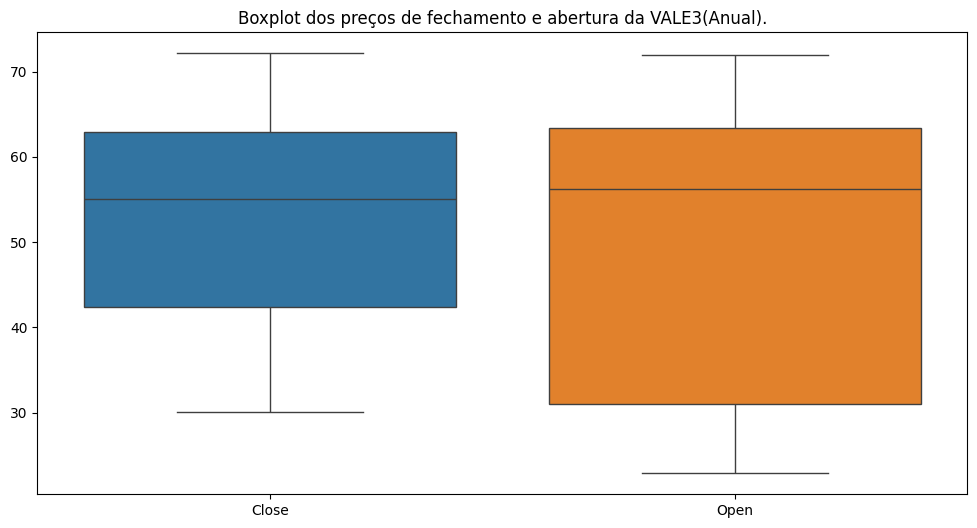

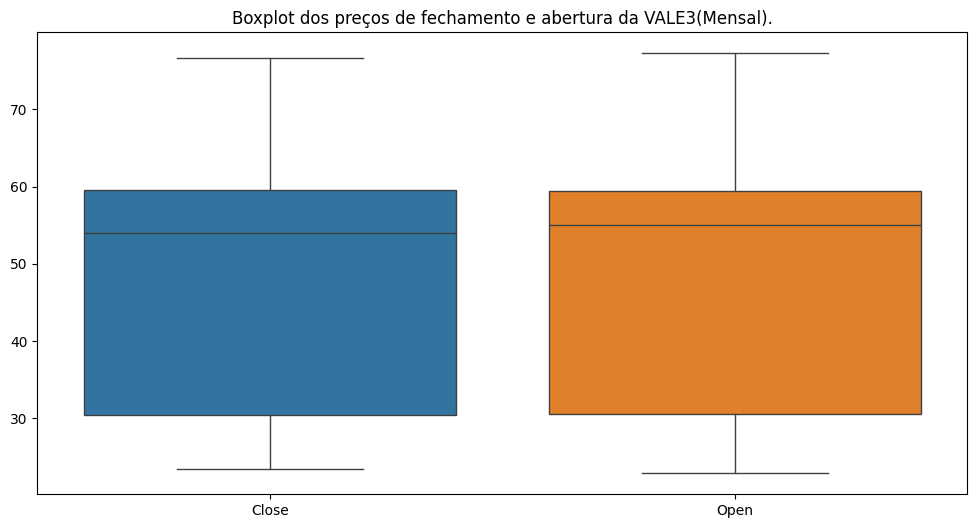

In [7]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_anual_CO[['Close', 'Open']])
plt.title('Boxplot dos preços de fechamento e abertura da VALE3(Anual).')
plt.figure(figsize=(12,6))
sns.boxplot(data=df_mensal_CO[['Close', 'Open']])
plt.title('Boxplot dos preços de fechamento e abertura da VALE3(Mensal).')

Text(0.5, 1.0, 'Boxplot dos preços de fechamento e abertura da VALE3(Mensal).')

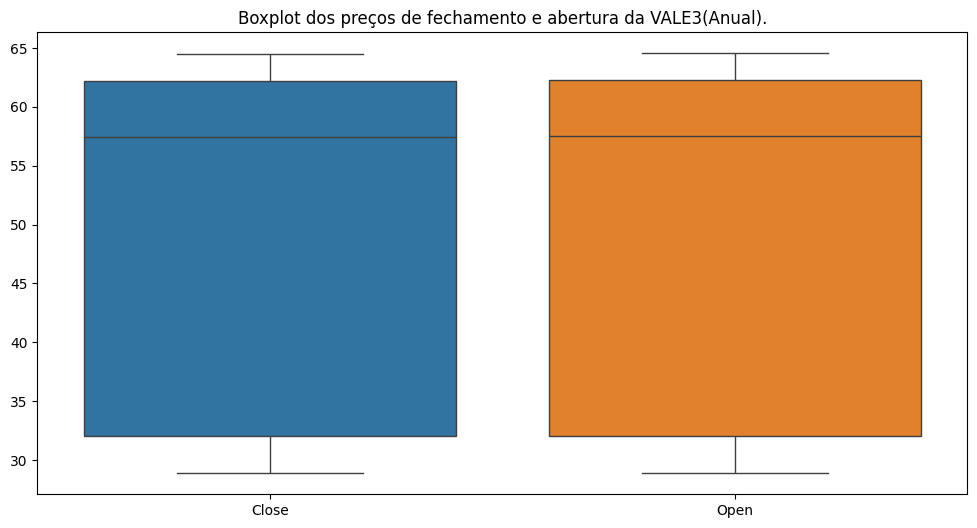

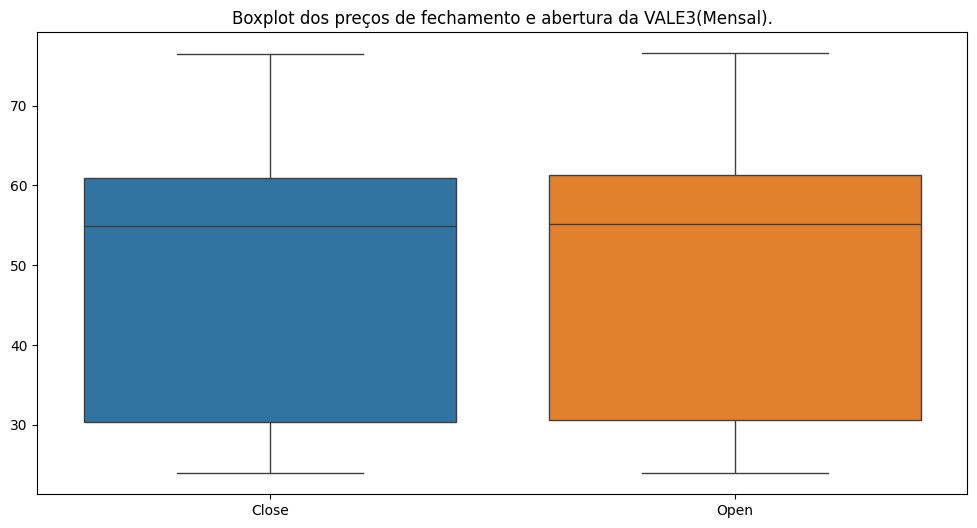

In [8]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_acoes_anos[['Close', 'Open']])
plt.title('Boxplot dos preços de fechamento e abertura da VALE3(Anual).')
plt.figure(figsize=(12,6))
sns.boxplot(data=df_acoes_meses[['Close', 'Open']])
plt.title('Boxplot dos preços de fechamento e abertura da VALE3(Mensal).')

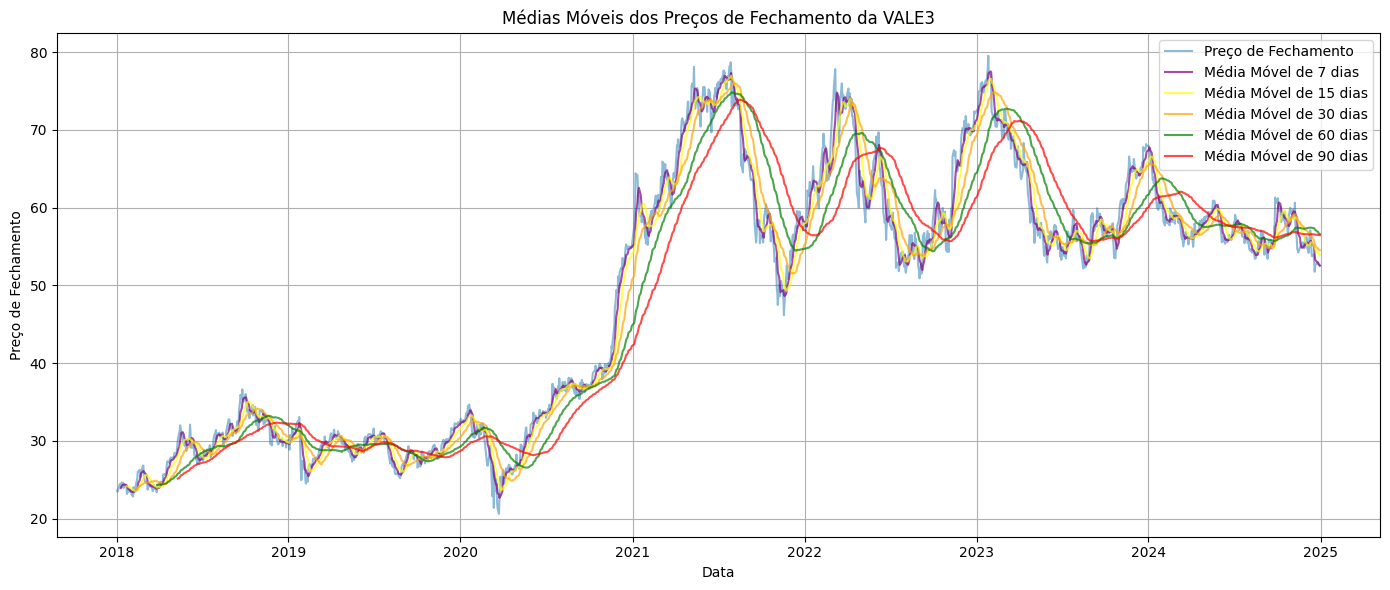

In [9]:
# Médias móveis:

plt.figure(figsize=(14,6))
plt.plot(vale['Close'], label='Preço de Fechamento',alpha=0.5)
plt.plot(vale['Close'].rolling(window=7).mean(), label='Média Móvel de 7 dias', color='purple', alpha=0.7)
plt.plot(vale['Close'].rolling(window=15).mean(), label='Média Móvel de 15 dias', color='yellow', alpha=0.7)
plt.plot(vale['Close'].rolling(window=30).mean(), label='Média Móvel de 30 dias', color='orange', alpha=0.7)
plt.plot(vale['Close'].rolling(window=60).mean(), label='Média Móvel de 60 dias', color='green', alpha=0.7)
plt.plot(vale['Close'].rolling(window=90).mean(), label='Média Móvel de 90 dias', color='red', alpha=0.7)
plt.title('Médias Móveis dos Preços de Fechamento da VALE3')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

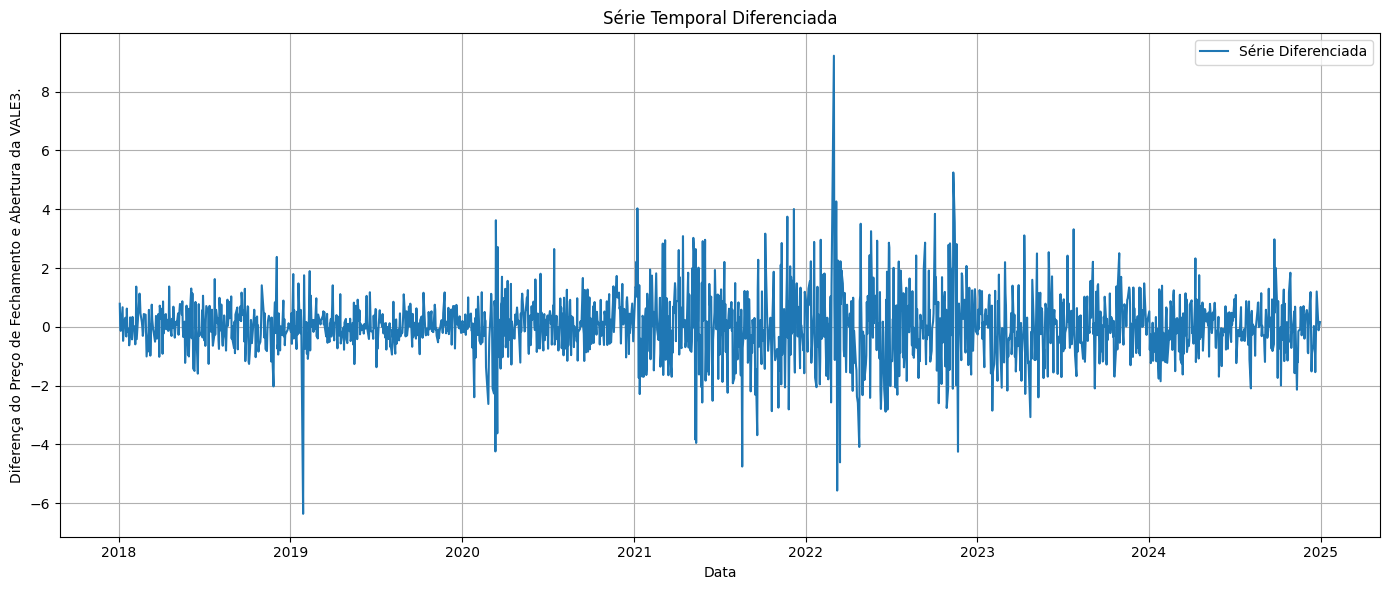

Estatística do teste: -16.056948829279058
Valor-p: 5.693616832966964e-29
Valores críticos:
1%: -3.4341355661448856
5%: -2.8632121160561694
10%: -2.5676601871094924


In [10]:
vale_diff = vale['Close'].diff().dropna()
vale_diff = vale['Open'].diff().dropna()

# Visualizando a série diferenciada
plt.figure(figsize=(14, 6))
plt.plot(vale_diff, label='Série Diferenciada')
plt.title('Série Temporal Diferenciada')
plt.xlabel('Data')
plt.ylabel('Diferença do Preço de Fechamento e Abertura da VALE3.')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Testando novamente a estacionariedade
resultado_adf_diff = adfuller(vale_diff, autolag='AIC')
print(f'Estatística do teste: {resultado_adf_diff[0]}')
print(f'Valor-p: {resultado_adf_diff[1]}')
print(f'Valores críticos:')
for chave, valor in resultado_adf_diff[4].items():
    print(f'{chave}: {valor}')